<a href="https://colab.research.google.com/github/raneymjohnGit/Austin_TX_House_Listings/blob/jayanbranch/Jayan/Analysis/Test_and_Compare_other_Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies, connect to SQL Database

In [ ]:
! pip install yellowbrick # Install Yellowbrick

In [213]:
# Import dependencies

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

from sklearn.model_selection import train_test_split # data split
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.regressor import PredictionError, ResidualsPlot, residuals_plot, prediction_error
from yellowbrick.features import feature_importances
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm



In [42]:
# Copy paste this code
# Install psycopg2-binary
! pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Copy paste this code
# URL for Heroku DB
raw_db_url='dpaclsxjrpfluk:4fa14e6fdb846bd14d1a9eda261d554fab9688f2f4dd5483bc38d94cdee010ad@ec2-3-219-52-220.compute-1.amazonaws.com:5432/d7s0s0hs0a5lar'

In [5]:
# Copy paste this code
 # Import SQL Alchemy, format url string for SQLAlchemy
 
import subprocess
from sqlalchemy.engine.create import create_engine

# Convert binary string to a regular string & remove the newline character
db_url = raw_db_url

# Convert "postgres://<db_address>"  --> "postgresql+psycopg2://<db_address>" needed for SQLAlchemy
final_db_url = "postgresql+psycopg2://" + db_url.lstrip("postgres://")  # lstrip() is more suitable here than replace() function since we only want to replace postgres at the start!


# Create SQLAlchemy engine
# ------------------------
engine = create_engine(final_db_url)

# Read in cleaned data from SQL as DataFrame


In [11]:
# SQL to dataframe using sqlalchemy
import pandas as pd

df = pd.read_sql_table('cleaned_data_1', engine)
df.head()

,index,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,...,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,month_year,latest_saledate_dt,dec_2019_price,jan_2021_price,price_per_sqft
0,6702,29415933,austin,5804 Bullard Dr,78757,"5804 Bullard Dr, Austin, TX 78757 is a single ...",30.336634,-97.750031,1.98,3,...,1153,16,2.0,3,1,2019-06,2019-06-21,470317,547114,202
1,4729,58304707,austin,823 Walnut Creek Dr,78753,"823 Walnut Creek Dr, Austin, TX 78753 is a sin...",30.386883,-97.668449,1.98,3,...,814,15,2.0,3,1,2019-02,2019-02-27,418299,486603,211
2,7501,29482307,austin,4410 Garnett St,78745,Complete remodel of a gorgeous vintage home. O...,30.218693,-97.770554,1.98,3,...,792,13,2.0,4,1,2019-07,2019-07-02,598560,696298,343
3,5146,29513449,austin,11412 Gun Fight Ln,78748,Large move-in ready Shady Hollow home loaded w...,30.162312,-97.854210,1.98,3,...,1633,17,4.0,5,2,2019-03,2019-03-20,481300,559890,137
4,5256,29479870,austin,1311 Casey St,78745,"1311 Casey St, Austin, TX 78745 is a single fa...",30.225712,-97.781837,1.98,3,...,803,12,2.0,3,1,2019-03,2019-03-11,374344,435470,300


In [12]:
# Drop non-numeric columns that will not be used for models, erroneus columns like index and jan_2021_price, and columns that are calculated from variables like price_per_sqft

df = df.drop(columns=['zpid', 'index', 'city', 'streetAddress', 'description', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'month_year', 'latest_saledate_dt', 'jan_2021_price', 'price_per_sqft', 'homeType', 'latestprice'])

# Cast Zip Code as string for hot encoding
df['zipcode'] = df['zipcode'].astype(str)

In [13]:
# Check datatypes to ensure we have correct features

df.dtypes

zipcode                        object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
parkingSpaces                   int64
yearBuilt                       int64
numOfAccessibilityFeatures      int64
numOfAppliances                 int64
numOfParkingFeatures            int64
numOfPatioAndPorchFeatures      int64
numOfSecurityFeatures           int64
numOfWaterfrontFeatures         int64
numOfWindowFeatures             int64
numOfCommunityFeatures          int64
lotSizeSqFt                   float64
livingAreaSqFt                float64
numOfPrimarySchools             int64
numOfElementarySchools          int64
numOfMiddleSchools              int64
numOfHighSch

In [138]:
# Define features and target
X = df.drop(["dec_2019_price"],axis = 1)
y = df.dec_2019_price

In [139]:
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object']).columns

In [137]:
numerical_ix

Index(['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'parkingSpaces', 'yearBuilt', 'numOfAccessibilityFeatures',
       'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories'],
      dtype='object')

In [136]:
categorical_ix

Index(['zipcode'], dtype='object')

# Random Forest with all 28 Features

In [132]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [133]:
# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [120]:
# Wrap the model with a pipeline
rf = RandomForestRegressor()
model = Pipeline([("preprocessing",ct),("model",rf)])
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['zipcode'], dtype='object'))])),
                ('model', RandomForestRegressor())])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


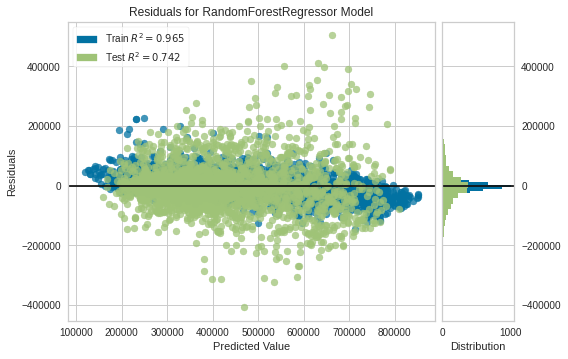

In [113]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


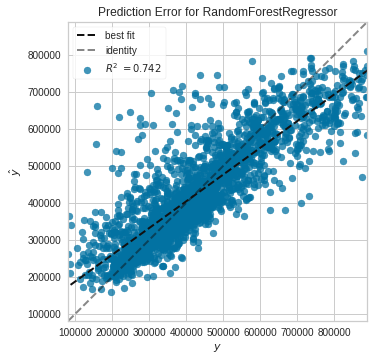

In [114]:
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [158]:
sel = SelectFromModel(estimator=model, importance_getter='named_steps.model.feature_importances_', prefit=True)
sel_feat_boolean = sel.get_support()
sel_feat_no_zips_boolean = sel_feat_boolean[-33:]

In [160]:
feature_names = ct.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [174]:
non_zip_columns = list(enumerate(X.columns))[-33:]
columns_df = pd.DataFrame(non_zip_columns, columns =['Number', 'Name'])
columns_df_cleaned = columns_df['Name']
selected_features = columns_df_cleaned[sel_feat_no_zips_boolean]

print(selected_features)

0              latitude
1             longitude
11            yearBuilt
13      numOfAppliances
20          lotSizeSqFt
21       livingAreaSqFt
26    avgSchoolDistance
27      avgSchoolRating
28        avgSchoolSize
Name: Name, dtype: object


In [179]:
col_list =  selected_features.to_list()
col_list.append('dec_2019_price')
col_list = ['zipcode'] + col_list
col_list

['zipcode',
 'latitude',
 'longitude',
 'yearBuilt',
 'numOfAppliances',
 'lotSizeSqFt',
 'livingAreaSqFt',
 'avgSchoolDistance',
 'avgSchoolRating',
 'avgSchoolSize',
 'dec_2019_price']

In [180]:
df_narrowed = df.copy(deep=True)
df_narrowed = df_narrowed[col_list]

In [183]:
# Define features and target
X = df_narrowed.drop(["dec_2019_price"],axis = 1)
y = df_narrowed.dec_2019_price

In [187]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

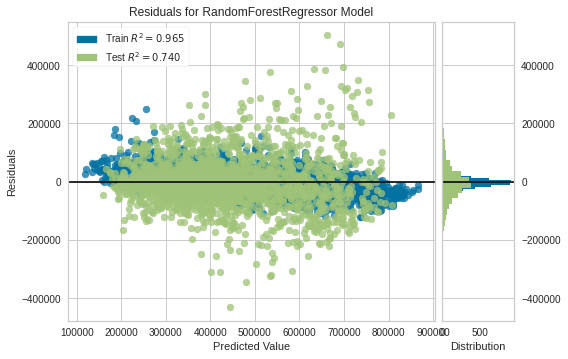

In [190]:
# Define Column Transformer
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
model = Pipeline([("preprocessing",ct),("model",rf)])
model.fit(X_train, y_train)
viz = residuals_plot(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


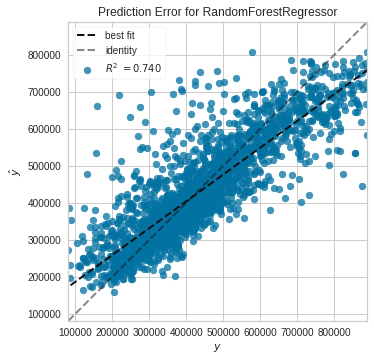

In [191]:
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [194]:
# Define features and target
X = df.drop(["dec_2019_price"],axis = 1)
y = df.dec_2019_price

In [195]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [196]:
# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

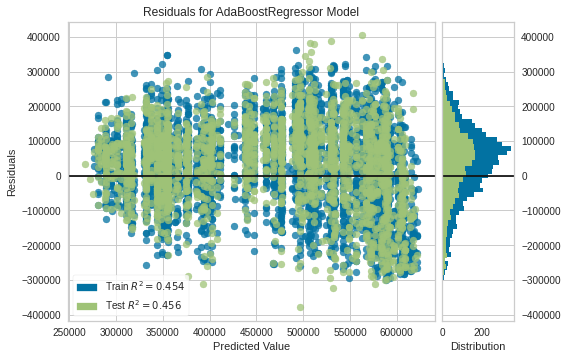

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


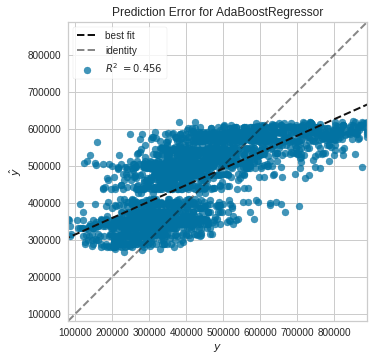

In [199]:
# Wrap the model with a pipeline
abr = AdaBoostRegressor(n_estimators=400)
model = Pipeline([("preprocessing",ct),("model",abr)])
model.fit(X_train, y_train)
viz = residuals_plot(model, X_train, y_train, X_test, y_test)
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


[22:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


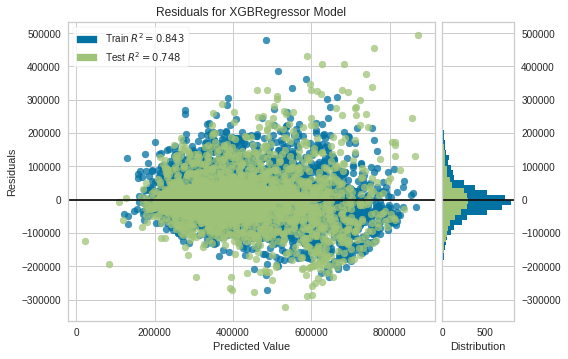

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


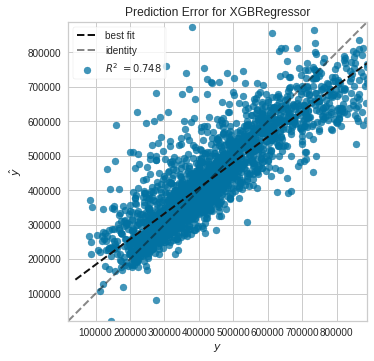

In [203]:
# Wrap the model with a pipeline
xgb = XGBRegressor(n_estimators=400)
model = Pipeline([("preprocessing",ct),("model",xgb)])
model.fit(X_train, y_train)
viz = residuals_plot(model, X_train, y_train, X_test, y_test)
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [204]:
df_narrowed = df.copy(deep=True)
df_narrowed = df_narrowed[col_list]

In [205]:
# Define features and target
X = df_narrowed.drop(["dec_2019_price"],axis = 1)
y = df_narrowed.dec_2019_price

In [206]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

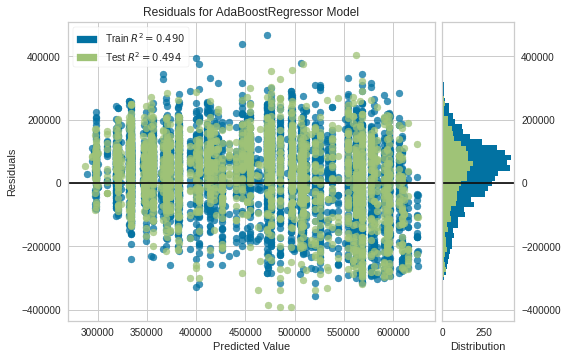

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


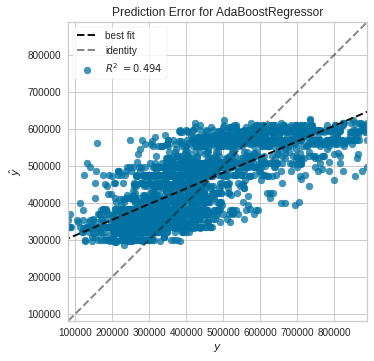

In [207]:
# Wrap the model with a pipeline
abr = AdaBoostRegressor(n_estimators=400)
model = Pipeline([("preprocessing",ct),("model",abr)])
model.fit(X_train, y_train)
viz = residuals_plot(model, X_train, y_train, X_test, y_test)
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


[22:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


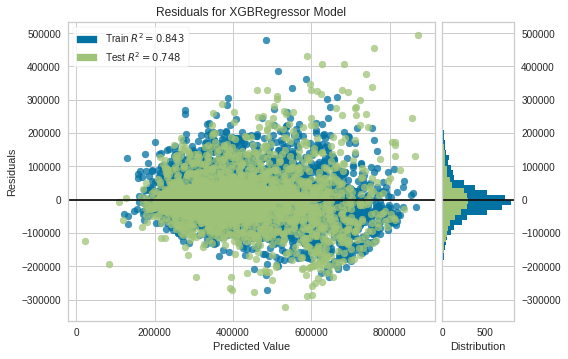

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


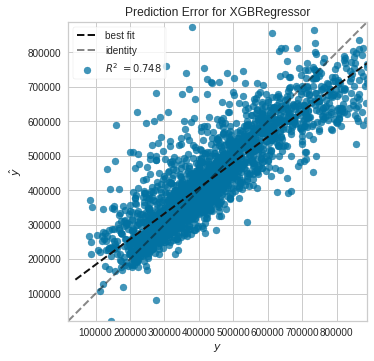

In [208]:
# Wrap the model with a pipeline
xgb = XGBRegressor(n_estimators=400)
model = Pipeline([("preprocessing",ct),("model",xgb)])
model.fit(X_train, y_train)
viz = residuals_plot(model, X_train, y_train, X_test, y_test)
visualizer = prediction_error(model, X_train, y_train, X_test, y_test)

In [209]:
# Define features and target
X = df.drop(["dec_2019_price"],axis = 1)
y = df.dec_2019_price

In [210]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [211]:
# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [216]:
# Linear Models with Pipeline

# 1. OLS

ols = LinearRegression()
ols_model = Pipeline([("preprocessing",ct),("model",ols)])
ols_model.fit(X_train, y_train)
ols_yhat = ols_model.predict(X_test)

# 2. Ridge

ridge = Ridge(alpha = 0.5)
ridge_model = Pipeline([("preprocessing",ct),("model",ridge)])
ridge_model.fit(X_train, y_train)
ridge_yhat = ridge_model.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.01)
lasso_model = Pipeline([("preprocessing",ct),("model",lasso)])
lasso_model.fit(X_train, y_train)
lasso_yhat = lasso_model.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge()
bayesian_model = Pipeline([("preprocessing",ct),("model",bayesian)])
bayesian_model.fit(X_train, y_train)
bayesian_yhat = bayesian_model.predict(X_test)

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
en_model = Pipeline([("preprocessing",ct),("model",en)])
en_model.fit(X_train, y_train)
en_yhat = en_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

In [217]:
# 1. Explained Variance Score

print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')


EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.6920955582473158
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.6919576378413046
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.6921004703362563
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.6918375486407761
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.678929419518937
-------------------------------------------------------------------------------


In [218]:
df_narrowed = df.copy(deep=True)
df_narrowed = df_narrowed[col_list]

In [219]:
# Define features and target
X = df_narrowed.drop(["dec_2019_price"],axis = 1)
y = df_narrowed.dec_2019_price

In [220]:
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')

In [221]:
# Linear Models with Pipeline

# 1. OLS

ols = LinearRegression()
ols_model = Pipeline([("preprocessing",ct),("model",ols)])
ols_model.fit(X_train, y_train)
ols_yhat = ols_model.predict(X_test)

# 2. Ridge

ridge = Ridge(alpha = 0.5)
ridge_model = Pipeline([("preprocessing",ct),("model",ridge)])
ridge_model.fit(X_train, y_train)
ridge_yhat = ridge_model.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.01)
lasso_model = Pipeline([("preprocessing",ct),("model",lasso)])
lasso_model.fit(X_train, y_train)
lasso_yhat = lasso_model.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge()
bayesian_model = Pipeline([("preprocessing",ct),("model",bayesian)])
bayesian_model.fit(X_train, y_train)
bayesian_yhat = bayesian_model.predict(X_test)

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
en_model = Pipeline([("preprocessing",ct),("model",en)])
en_model.fit(X_train, y_train)
en_yhat = en_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/s

In [222]:
# 1. Explained Variance Score

print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')

EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.6920955582473158
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.6919576378413046
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.6921004703362563
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.6918375486407761
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.678929419518937
-------------------------------------------------------------------------------


In [185]:
# Define Data preparation for columns if scaling data
t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
ct = ColumnTransformer(transformers=t, remainder='passthrough')